In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

2023-12-07 13:28:03.455838: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Boston housing classification

This is a continuation of the Boston housing regression notebook. Go through that notebook first. Here, we will not provide any additional information on the preliminary steps.

In [2]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

Minimal preprocessing

In [3]:
X_train, X_rest, Y_train, Y_rest = train_test_split(data, target, test_size=0.3) # Set aside 30% of the data set
X_test, X_val, Y_test, Y_val = train_test_split(X_rest, Y_rest, test_size=0.5) # Split this 30% in half

X_mean = np.mean(X_train, axis=0)
X_std = np.std(X_train, axis=0)

X_train_n = (X_train - X_mean) / X_std
X_test_n = (X_test - X_mean) / X_std
X_val_n = (X_val - X_mean) / X_std

# Convert outcome to binary event
Y_train_class = (Y_train > 25)*1
Y_test_class = Y_test > 25
Y_test_class = Y_test > 25

In [4]:
n_dim = len(X_train[0])

inputs = Input(shape=(n_dim,))
x = Dense(30, activation='relu')(inputs)  # Look up what the function is of 'relu'
x = Dense(30, activation='relu')(x)
x = Dense(30, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)

# Create the actual model
model = Model(inputs=inputs, outputs=outputs)

# Compile
model.compile(optimizer='adam', loss='binary_crossentropy')  # Use 'categorical_crossentropy' for classification

# Get a summary of the model, check if everything is as intended
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 13)]              0         
                                                                 
 dense (Dense)               (None, 30)                420       
                                                                 
 dense_1 (Dense)             (None, 30)                930       
                                                                 
 dense_2 (Dense)             (None, 30)                930       
                                                                 
 dense_3 (Dense)             (None, 1)                 31        
                                                                 
Total params: 2311 (9.03 KB)
Trainable params: 2311 (9.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [6]:
model.fit(X_train_n, Y_train_class, epochs=500, batch_size=50, verbose=0)

In [7]:
predictions = model.predict(X_test_n, verbose=0) > 0.5

In [8]:
conf_matrix = confusion_matrix(Y_test_class, predictions)

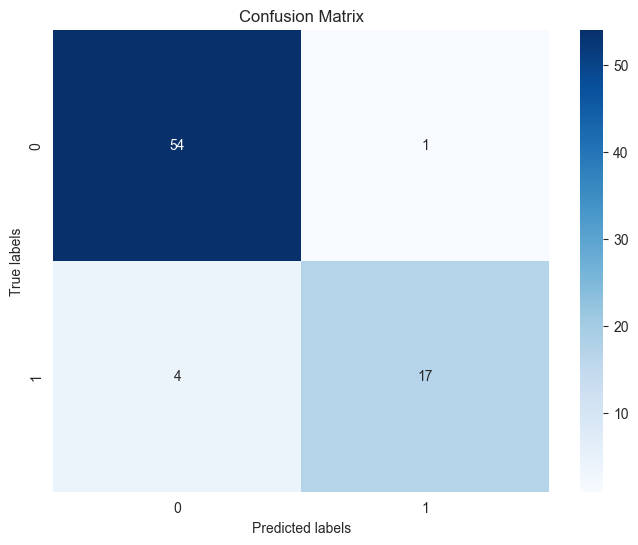

In [9]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## Comparing to a GLM

In [10]:
# Add intercept
X = sm.add_constant(X_train_n)
X_test_glm = sm.add_constant(X_test_n)

# Fit GLM
glm_model = sm.GLM(Y_train_class, X, family=sm.families.Binomial())
glm_model_fitted = glm_model.fit()

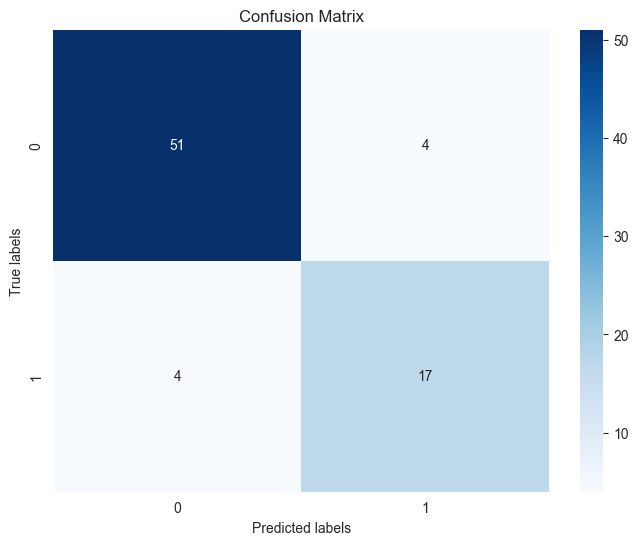

In [11]:
predictions = glm_model_fitted.predict(X_test_glm)
predicted_classes = (predictions > 0.5).astype(int)
conf_matrix = confusion_matrix(Y_test_class, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## Hyperparameter tuning

Again, we did not implement the standard hyperparameter search. The model already seems to perform well but it in general we can greatly improve the model.